## 工作流程
1. 數據清洗與格式轉換
2. 探索性數據分析
3. 特徵工程
4. 建立基礎模型，嘗試多種算法
5. 模型調參
6. 評估與測試

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

## 數據清洗



In [2]:
pd.set_option('display.max_columns', 60)
data = pd.read_csv('data/Energy_and_Water_Data_Disclosure_for_Local_Law_84_2017__Data_for_Calendar_Year_2016_.csv')
data.head()

,Order,Property Id,Property Name,Parent Property Id,Parent Property Name,BBL - 10 digits,"NYC Borough, Block and Lot (BBL) self-reported",NYC Building Identification Number (BIN),Address 1 (self-reported),Address 2,Postal Code,Street Number,Street Name,Borough,DOF Gross Floor Area,Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type,Largest Property Use Type - Gross Floor Area (ft²),2nd Largest Property Use Type,2nd Largest Property Use - Gross Floor Area (ft²),3rd Largest Property Use Type,3rd Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings - Self-reported,Occupancy,Metered Areas (Energy),Metered Areas (Water),ENERGY STAR Score,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Weather Normalized Source EUI (kBtu/ft²),Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),District Steam Use (kBtu),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Property GFA - Self-Reported (ft²),Water Use (All Water Sources) (kgal),Water Intensity (All Water Sources) (gal/ft²),Source EUI (kBtu/ft²),Release Date,Water Required?,DOF Benchmarking Submission Status,Latitude,Longitude,Community Board,Council District,Census Tract,NTA
0,1,13286,201/205,13286,201/205,1013160001,1013160001,1037549,201/205 East 42nd st.,Not Available,10017,675,3 AVENUE,Manhattan,289356.0,Office,Office,Office,293447,Not Available,Not Available,Not Available,Not Available,1963,2,100,Whole Building,Not Available,Not Available,305.6,303.1,37.8,Not Available,614.2,Not Available,Not Available,Not Available,Not Available,Not Available,5.15506751E7,Not Available,Not Available,38139374.2,1.10827705E7,6962.2,0,6962.2,762051,Not Available,Not Available,619.4,05/01/2017 05:32:03 PM,No,In Compliance,40.750791,-73.973963,6.0,4.0,88.0,Turtle Bay-East Midtown ...
1,2,28400,NYP Columbia (West Campus),28400,NYP Columbia (West Campus),1021380040,1-02138-0040,1084198; 1084387;1084385; 1084386; 1084388; 10...,622 168th Street,Not Available,10032,180,FT WASHINGTON AVENUE,Manhattan,3693539.0,Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),3889181,Not Available,Not Available,Not Available,Not Available,1969,12,100,Whole Building,Whole Building,55,229.8,228.8,24.8,2.4,401.1,Not Available,1.96248472E7,Not Available,Not Available,Not Available,-3.914148026E8,933073441,9330734.4,332365924,9.62613121E7,55870.4,51016.4,4854.1,3889181,Not Available,Not Available,404.3,04/27/2017 11:23:27 AM,No,In Compliance,40.841402,-73.942568,12.0,10.0,251.0,Washington Heights South ...
2,3,4778226,MSCHoNY North,28400,NYP Columbia (West Campus),1021380030,1-02138-0030,1063380,3975 Broadway,Not Available,10032,3975,BROADWAY,Manhattan,152765.0,Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),231342,Not Available,Not Available,Not Available,Not Available,1924,1,100,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,0,0,0,231342,Not Available,Not Available,Not Available,04/27/2017 11:23:27 AM,No,In Compliance,40.840427,-73.940249,12.0,10.0,251.0,Washington Heights South ...
3,4,4778267,Herbert Irving Pavilion & Millstein Hospital,28400,NYP Columbia (West Campus),1021390001,1-02139-0001,1087281; 1076746,161 Fort Washington Ave,177 Fort Washington Ave,10032,161,FT WASHINGTON AVENUE,Manhattan,891040.0,Hos

詳細的數據信息：[數據簡介](http://www.nyc.gov/html/gbee/downloads/misc/nyc_benchmarking_disclosure_data_definitions_2017.pdf)<br>
目標是預測最終的得分值，1-100表示建築的能源得分值，1代表利用率很差，100表示很高

### 數據類型與缺失值
`dataframe.info` 可以快速讓知道數據類型與缺失值

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11746 entries, 0 to 11745
Data columns (total 60 columns):
Order                                                         11746 non-null int64
Property Id                                                   11746 non-null int64
Property Name                                                 11746 non-null object
Parent Property Id                                            11746 non-null object
Parent Property Name                                          11746 non-null object
BBL - 10 digits                                               11735 non-null object
NYC Borough, Block and Lot (BBL) self-reported                11746 non-null object
NYC Building Identification Number (BIN)                      11746 non-null object
Address 1 (self-reported)                                     11746 non-null object
Address 2                                                     11746 non-null object
Postal Code                                          

這份數據中的缺失值標記為"Not Available" 並不是常見的 `np.nan` (not a number)<br>
首先將"Not Available"轉換為 `np.nan` ，再將部分數值型數據轉換成float

In [4]:
# 將Not Available換成nan
data = data.replace(['Not Available'] , [np.nan])

for col in list(data.columns):
    # 名稱包含ft²、kBtu、Metric Tons CO2e、kWh、therms、gal、Score的特徵都要轉換成float
    if ('ft²' in col or
        'kBtu' in col or
        'Metric Tons CO2e' in col or
        'kWh' in col or
        'therms' in col or
        'gal' in col or
        'Score' in col):
        data[col] = data[col].astype(np.float32)

In [5]:
data.describe()

,Order,Property Id,DOF Gross Floor Area,Largest Property Use Type - Gross Floor Area (ft²),2nd Largest Property Use - Gross Floor Area (ft²),3rd Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings - Self-reported,Occupancy,ENERGY STAR Score,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Weather Normalized Source EUI (kBtu/ft²),Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),District Steam Use (kBtu),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Property GFA - Self-Reported (ft²),Water Use (All Water Sources) (kgal),Water Intensity (All Water Sources) (gal/ft²),Source EUI (kBtu/ft²),Latitude,Longitude,Community Board,Council District,Census Tract
count,11746.000000,1.174600e+04,1.162800e+04,1.174400e+04,3741.000000,1484.000000,11746.000000,11746.000000,11746.000000,9642.000000,11583.000000,10281.000000,10959.000000,9783.000000,10281.000000,9.000000e+00,2.581000e+03,1321.00,594.0,1.600000e+01,9.360000e+02,1.030400e+04,9.784000e+03,1.150200e+04,1.096000e+04,1.167200e+04,1.166300e+04,1.168100e+04,1.174600e+04,7.762000e+03,7762.000000,11583.000000,9483.000000,9483.000000,9483.000000,9483.000000,9483.000000
mean,7185.759578,3.642958e+06,1.732695e+05,1.605524e+05,22778.681641,12016.825195,1948.738379,1.289971,98.762557,59.854595,280.071472,309.747467,11.072643,1.901441,417.915710,3.395398e+06,3.186882e+06,5294367.00,2429105.5,1.193594e+06,2.868907e+08,5.048546e+07,5.364578e+05,5.965472e+06,1.768752e+06,4.553658e+03,2.477937e+03,2.076339e+03,1.673739e+05,1.591798e+04,136.172424,385.908051,40.754379,-73.957057,7.140673,15.771275,4977.596647
std,4323.859984,1.049070e+06,3.367055e+05,3.095746e+05,55094.441406,27959.755859,30.576386,4.017484,7.501603,29.993586,8607.178711,9784.731445,127.733864,97.204590,10530.524414,2.213237e+06,5.497154e+06,5881863.50,4442945.5,3.558178e+06,3.124603e+09,3.914719e+09,4.022606e+07,3.154430e+07,9.389154e+06,2.041639e+05,1.954498e+05,5.931295e+04,3.189238e+05,1.529524e+05,1730.726929,9312.736328,0.080120,0.046337,3.954129,15.674375,13520.422990
min,1.000000,7.365000e+03,5.002800e+04,5.400000e+01,0.000000,0.000000,1600.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.085973e+05,0.000000e+00,0.00,0.0,0.000000e+00,-4.690797e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.313430e+04,0.000000e+00,0.000000e+00,0.000000,0.000000,40.516065,-74.243582,1.000000,1.000000,1.000000
25%,3428.250000,2.747222e+06,6.524000e+04,6.520100e+04,4000.000000,1720.750000,1927.000000,1.000000,100.000000,37.000000,61.799999,65.099998,3.800000,0.100000,103.500000,1.663594e+06,2.550378e+05,2128212.75,0.0,5.698020e+04,4.320254e+06,1.098251e+06,1.176953e+04,1.043673e+06,3.019975e+05,3.287000e+02,1.474500e+02,9.480000e+01,6.699400e+04,2.595400e+03,27.150000,99.400002,40.707226,-73.984662,4.000000,4.000000,100.000000
50%,6986.500000,3.236404e+06,9.313850e+04,9.132400e+04,8654.000000,5000.000000,1941.000000,1.000000,100.000000,65.000000,78.500000,82.500000,5.300000,0.500000,129.399994,4.328816e+06,1.380138e+06,4312984.50,0.0,2.070020e+05,9.931240e+06,4.103962e+06,4.445525e+04,1.855196e+06,5.416312e+05,5.002500e+02,2.726000e+02,1.718000e+02,9.408000e+04,4.692500e+03,45.095001,124.900002,40.759130,-73.962810,7.000000,9.000000,201.000000
75%,11054.500000,4.409092e+06,1.596140e+05,1.532550e+05,20000.000000,12000.000000,1966.000000,1.000000,100.000000,85.000000,97.599998,102.500000,9.200000,0.700000,167.199997,4.938946e+06,4.445808e+06,6514520.00,4293825.5,2.918332e+05,2.064497e+07,6.855070e+06,7.348108e+04,4.370302e+06,1.284676e+06

### 缺失值處理
看一下每列的缺失值比例，有很多種方法可以做，這裡的這一個函數，還蠻好用的

In [6]:
def missing_values_table(data):
    missing_value = data.isnull().sum()
    missing_value_percent = data.isnull().sum() / data.shape[0] * 100
    missing_value_table = pd.concat([missing_value , missing_value_percent] , axis = 1)
    missing_value_table = missing_value_table.rename(columns = {0 : 'Missing Values' , 1 : '% of Total Values'})
    missing_value_table.sort_values('% of Total Values' , ascending = False , inplace = True)
    print('總共有{}個column，有{}個特徵有缺失值'.format(len(missing_value_table) , (missing_value_table['% of Total Values'] != 0).sum()))
    return missing_value_table.loc[missing_value_table['% of Total Values'] != 0]
    
missing_data = missing_values_table(data)

總共有60個column，有46個特徵有缺失值


In [7]:
missing_data.head(20)

,Missing Values,% of Total Values
Fuel Oil #1 Use (kBtu),11737,99.923378
Diesel #2 Use (kBtu),11730,99.863783
Address 2,11539,98.237698
Fuel Oil #5 & 6 Use (kBtu),11152,94.942959
District Steam Use (kBtu),10810,92.031330
Fuel Oil #4 Use (kBtu),10425,88.753618
3rd Largest Property Use Type - Gross Floor Area (ft²),10262,87.365912
3rd Largest Property Use Type,10262,87.365912
Fuel Oil #2 Use (kBtu),9165,78.026562
2nd Largest Property Use - Gross Floor Area (ft²),8005,68.150860


如果特徵缺失值實在比例太高，就刪除該特徵<br>

In [9]:
# 刪除缺失值大於50%的特徵
missing_columns = list(missing_data[missing_data['% of Total Values'] > 50].index)
print('有缺失值超過50%的column的數目 : {}\n'.format(len(missing_columns)))

for col in missing_columns :
    print(col)
    
data = data.drop(columns = missing_columns)

有缺失值超過50%的column的數目 : 11

Fuel Oil #1 Use (kBtu)
Diesel #2 Use (kBtu)
Address 2
Fuel Oil #5 & 6 Use (kBtu)
District Steam Use (kBtu)
Fuel Oil #4 Use (kBtu)
3rd Largest Property Use Type - Gross Floor Area (ft²)
3rd Largest Property Use Type
Fuel Oil #2 Use (kBtu)
2nd Largest Property Use - Gross Floor Area (ft²)
2nd Largest Property Use Type


In [10]:
# 這個函數真的是好用!!
# 若是想要針對數值型數據做更詳細的統計指標，可以用這個函數
def status(x) : 
    return pd.Series([x.count() , x.min() , x.idxmin() , x.quantile(.25) , x.median(), x.quantile(0.75) , 
                      x.mean() , x.max() , x.idxmax() , x.mad() , x.var(), x.std() , x.skew() , x.kurt()] , 
                      index=['count' , 'min' , 'min_index' , '25%' , '50%' , '75%' , 'mean' , 'max' , 'max_index' , 'mad' , 'var' , 'std' , 'skew' , 'kurt'])

# 類別型數據 => object_features
# 數值型數據 => number_feature
object_features = []
for col in data.columns:
    if data[col].dtypes == 'object':
        object_features.append(col)
number_feature = list(set(list(data.columns)).difference(set(object_features))) # 把dtype為'object'的column剃除

number_describe = data[number_feature].apply(status)
object_describe = data[object_features].describe()

In [11]:
number_describe.head()

,Community Board,Order,Occupancy,Weather Normalized Site Natural Gas Use (therms),Direct GHG Emissions (Metric Tons CO2e),Property GFA - Self-Reported (ft²),Weather Normalized Source EUI (kBtu/ft²),Natural Gas Use (kBtu),Latitude,Total GHG Emissions (Metric Tons CO2e),ENERGY STAR Score,Water Intensity (All Water Sources) (gal/ft²),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Year Built,Longitude,Indirect GHG Emissions (Metric Tons CO2e),Council District,Weather Normalized Site Natural Gas Intensity (therms/ft²),Census Tract,Largest Property Use Type - Gross Floor Area (ft²),Water Use (All Water Sources) (kgal),Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Source EUI (kBtu/ft²),Number of Buildings - Self-reported,DOF Gross Floor Area,Weather Normalized Site Electricity Intensity (kWh/ft²),Property Id
count,9483.0,11746.00,11746.0,9784.000000,11663.000000,11746.0,10281.000000,10304.00,9483.000000,11672.000000,9642.0,7762.000000,1.150200e+04,10960.00000,11746.0,9483.000000,11681.000000,9483.0,9783.0,9483.0,11744.0,7762.000000,11583.000000,10281.000000,11583.000000,11746.0,11628.0,10959.0,11746.0
min,1.0,1.00,0.0,0.000000,0.000000,0.0,0.000000,0.00,40.516065,0.000000,1.0,0.000000,0.000000e+00,0.00000,1600.0,-74.243582,-23134.300781,1.0,0.0,1.0,54.0,0.000000,0.000000,0.000000,0.000000,0.0,50028.0,0.0,7365.0
min_index,106.0,0.00,269.0,25.000000,0.000000,771.0,25.000000,25.00,11733.000000,2.000000,13.0,167.000000,2.500000e+01,25.00000,554.0,11733.000000,5.000000,27.0,12.0,7455.0,8268.0,167.000000,25.000000,25.000000,25.000000,28.0,5045.0,24.0,2290.0
25%,4.0,3428.25,100.0,11769.525391,147.449997,66994.0,103.500000,1098250.75,40.707226,328.700012,37.0,27.150000,1.043673e+06,301997.46875,1927.0,-73.984662,94.800003,4.0,0.1,100.0,65201.0,2595.400146,61.799999,65.099998,99.400002,1.0,65240.0,3.8,2747221.5
50%,7.0,6986.50,100.0,44455.250000,272.600006,94080.0,129.399994,4103962.00,40.759130,500.250000,65.0,45.095001,1.855196e+06,541631.25000,1941.0,-73.962810,171.800003,9.0,0.5,201.0,91324.0,4692.500000,78.500000,82.500000,124.900002,1.0,93138.5,5.3,3236403.5


In [12]:
object_describe.head()

,Property Name,Parent Property Id,Parent Property Name,BBL - 10 digits,"NYC Borough, Block and Lot (BBL) self-reported",NYC Building Identification Number (BIN),Address 1 (self-reported),Postal Code,Street Number,Street Name,Borough,Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type,Metered Areas (Energy),Metered Areas (Water),Release Date,Water Required?,DOF Benchmarking Submission Status,NTA
count,11746,11746,11746,11735,11735,11584,11746,11746,11622,11624,11628,11746,11746,11744,11689,7137,11746,11628,11716,9483
unique,11740,102,103,11580,11581,11507,11645,286,4198,2024,5,55,813,53,7,6,3537,2,1,144
top,Main Hospital,Not Applicable: Standalone Property,Not Applicable: Standalone Property,1019730001,1019730001,4455379,410 West 118th Street,10022,1,BROADWAY,Manhattan,Multifamily Housing,Multifamily Housing,Multifamily Housing,Whole Building,Whole Building,05/01/2017 02:58:14 PM,Yes,In Compliance,Midtown-Midtown South ...
freq,2,11324,11324,26,26,13,12,269,66,390,5176,8688,6182,8694,11648,7111,1258,7552,11716,720


### Exploratory Data Analysis(EDA)

### 單變數繪圖

先看最重要的標簽數據

Text(0.5, 1.0, 'Energy Star Score Distribution')

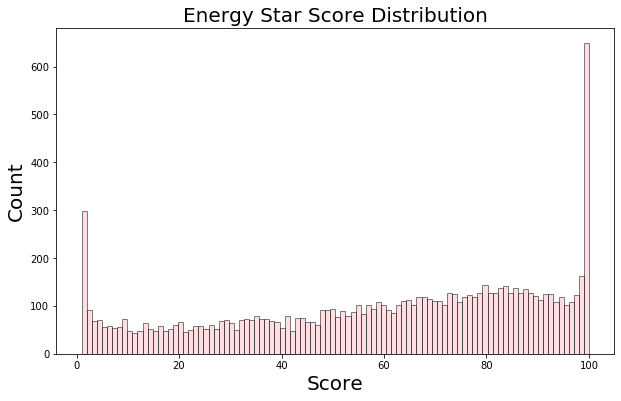

In [15]:
data = data.rename(columns = {'ENERGY STAR Score': 'score'})

fig , ax = plt.subplots(1 , 1 , figsize = (10 , 6))
ax.hist(data['score'].dropna() , alpha = 0.5 , color = 'pink' , bins = 100 , edgecolor = 'k')
ax.set_xlabel('Score' , fontsize = 20)
ax.set_ylabel('Count' , fontsize = 20)
ax.set_title('Energy Star Score Distribution' , fontsize = 20)

看起來0,100這兩個極端很多，其實數據描述中看到了一點，自我報告，也就是這份數據的評分是由個人來提交<br>

Energy Use Intensity (EUI)：the total energy use divided by the square footage of the building. 這個指標應該更合理一些

Text(0.5, 1.0, 'Site EUI Distribution')

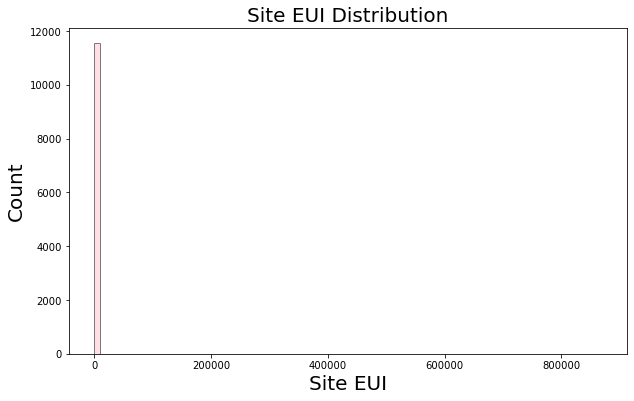

In [16]:
fig , ax = plt.subplots(1 , 1 , figsize = (10 , 6))
ax.hist(data['Site EUI (kBtu/ft²)'].dropna() , alpha = 0.5 , color = 'pink' , bins = 100 , edgecolor = 'k')
ax.set_xlabel('Site EUI' , fontsize = 20)
ax.set_ylabel('Count' , fontsize = 20)
ax.set_title('Site EUI Distribution' , fontsize = 20)

但這個圖還蠻不合理的，應該出了一些問題

In [17]:
data['Site EUI (kBtu/ft²)'].describe()

count     11583.000000
mean        280.071472
std        8607.178711
min           0.000000
25%          61.799999
50%          78.500000
75%          97.599998
max      869265.000000
Name: Site EUI (kBtu/ft²), dtype: float64

In [18]:
data['Site EUI (kBtu/ft²)'].value_counts().sort_index(ascending = False) # 也可以藉由這一行看出一些問題

869265.000000     1
143974.406250     1
126307.398438     1
112173.601562     1
103562.703125     1
                 ..
0.400000          1
0.300000          3
0.200000          1
0.100000          2
0.000000         18
Name: Site EUI (kBtu/ft²), Length: 1958, dtype: int64

可以看到存在著一些特別大的值，這些可能是離群點或記錄錯誤點，對結果一定有影響

### 剔除離群點 (https://www.itl.nist.gov/div898/handbook/prc/section1/prc16.htm)

離群點的選擇可能需要再斟酌一些，這裏選擇的方法是extreme outlier

*   $\text{First Quartile} -3 * \text{Interquartile Range}$
*   $\text{Third Quartile} + 3 * \text{Interquartile Range}$

In [19]:
# 計算第1分位數與第3分位數
first_quartile = data['Site EUI (kBtu/ft²)'].describe()['25%']
third_quartile = data['Site EUI (kBtu/ft²)'].describe()['75%']
iqr = third_quartile - first_quartile

condition_1 = (data['Site EUI (kBtu/ft²)'] > (first_quartile - 3 * iqr)) 
condition_2 = (data['Site EUI (kBtu/ft²)'] < (third_quartile + 3 * iqr))
data = data.loc[condition_1 & condition_2]

剔除離群點之後，再來看看分布情況

Text(0.5, 1.0, 'Site EUI Distribution')

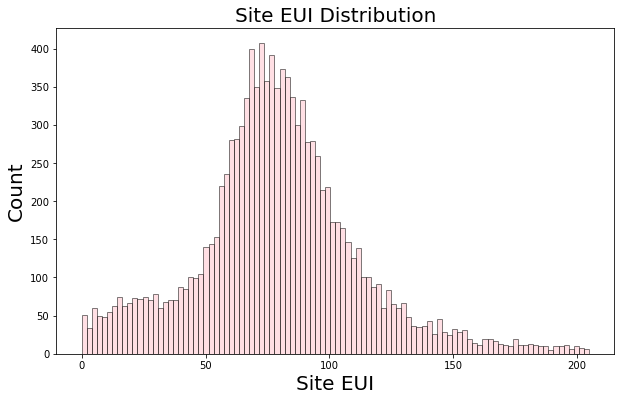

In [20]:
fig , ax = plt.subplots(1 , 1 , figsize = (10 , 6))
ax.hist(data['Site EUI (kBtu/ft²)'].dropna() , alpha = 0.5 , color = 'pink' , bins = 100 , edgecolor = 'k')
ax.set_xlabel('Site EUI' , fontsize = 20)
ax.set_ylabel('Count' , fontsize = 20)
ax.set_title('Site EUI Distribution' , fontsize = 20)

### 觀察哪些變數會對結果產生影響

In [21]:
types = data.dropna(subset = ['score'])
types = types['Largest Property Use Type'].value_counts()
types

Multifamily Housing                      7464
Office                                   1157
Hotel                                     202
Non-Refrigerated Warehouse                156
K-12 School                                97
Residence Hall/Dormitory                   96
Senior Care Community                      85
Distribution Center                        61
Retail Store                               57
Medical Office                             23
Hospital (General Medical & Surgical)      15
Financial Office                           12
Supermarket/Grocery Store                  10
Worship Facility                            9
Refrigerated Warehouse                      8
Parking                                     3
Wholesale Club/Supercenter                  3
Courthouse                                  2
Bank Branch                                 1
Name: Largest Property Use Type, dtype: int64

In [22]:
types = list(types[types > 90].index) # 選擇types中數據量大於90筆的，拿出來看看對score有什麼影響

Text(0.5, 1.0, 'Density Plot of Energy Star Scores by Building Type')

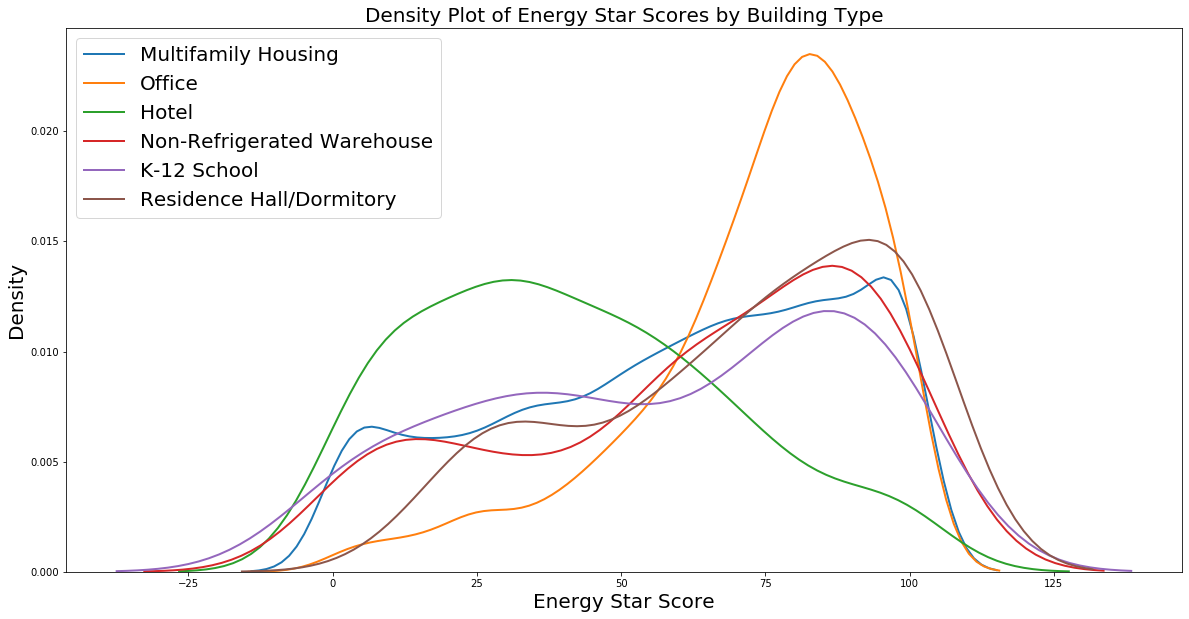

In [23]:
fig , ax = plt.subplots(1 , 1 , figsize = (20 , 10))

for type_ in types:
    subset = data.loc[data['Largest Property Use Type'] == type_]
    sns.kdeplot(subset['score'].dropna() , label = type_ , linewidth = 2);
    
ax.set_xlabel('Energy Star Score' , fontsize = 20)
ax.set_ylabel('Density' , fontsize = 20)
ax.legend(fontsize = 20)
ax.set_title('Density Plot of Energy Star Scores by Building Type' , fontsize = 20)

不同類型的建築看起來對結果的影響是不一樣的，所以需要充分利用這個變數

In [24]:
boroughs = data.dropna(subset = ['score'])
boroughs = boroughs['Borough'].value_counts()
boroughs = list(boroughs.index)

Text(0.5, 1.0, 'Density Plot of Energy Star Scores by Borough')

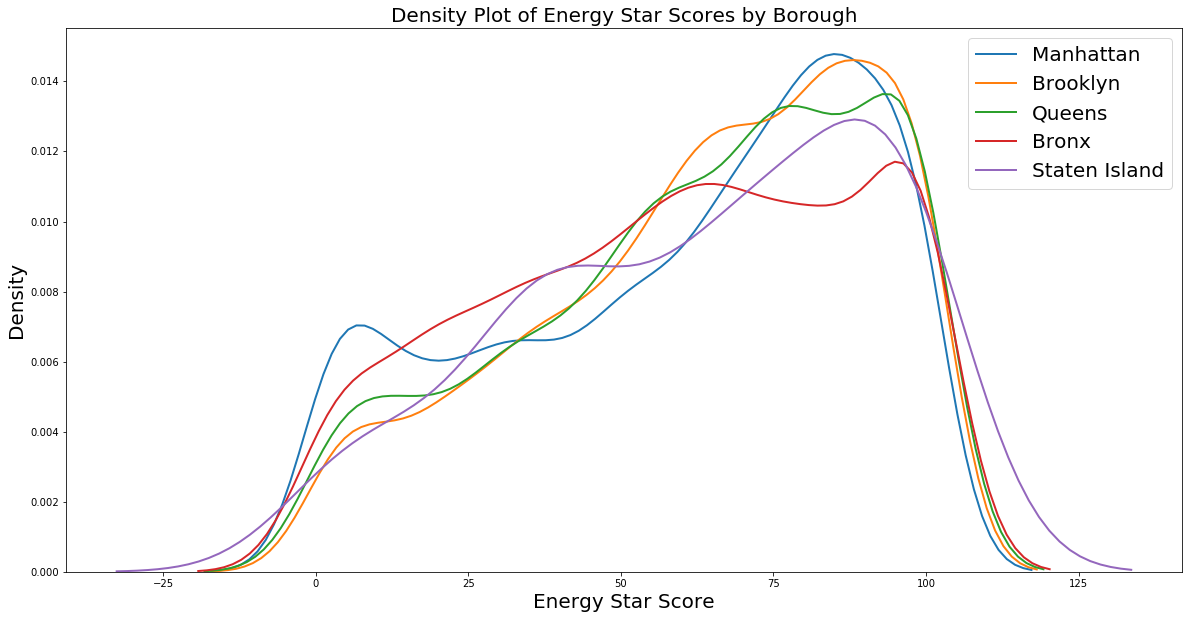

In [25]:
fig , ax = plt.subplots(1 , 1 , figsize = (20 , 10))

for borough in boroughs:
    subset = data.loc[data['Borough'] == borough]
    sns.kdeplot(subset['score'].dropna() , label = borough , linewidth = 2);
    
ax.set_xlabel('Energy Star Score' , fontsize = 20)
ax.set_ylabel('Density' , fontsize = 20)
ax.legend(fontsize = 20)
ax.set_title('Density Plot of Energy Star Scores by Borough' , fontsize = 20)

對於Borough這個特徵來說看起來對結果的影響就不大，因為分布情況都差不多

### 特征和標簽之間的相關性
看一下各個特徵與`score`之間的相關係數，幫助來篩選特徵
![](correlation_examples.png)

In [26]:
correlations_wirth_score = data.corr()['score'].sort_values()
pd.DataFrame(correlations_wirth_score).head(20)

,score
Site EUI (kBtu/ft²),-0.723864
Weather Normalized Site EUI (kBtu/ft²),-0.713993
Weather Normalized Source EUI (kBtu/ft²),-0.645542
Source EUI (kBtu/ft²),-0.641037
Weather Normalized Site Electricity Intensity (kWh/ft²),-0.358394
Weather Normalized Site Natural Gas Intensity (therms/ft²),-0.346046
Direct GHG Emissions (Metric Tons CO2e),-0.147792
Weather Normalized Site Natural Gas Use (therms),-0.135211
Natural Gas Use (kBtu),-0.133648
Year Built,-0.121249


`Site EUI (kBtu/ft²)`和  `Weather Normalized Site EUI (kBtu/ft²)` 呈現出明顯的負相關，單位用電量越多，能源利用得分越低<br>

### 雙變數繪圖

In [31]:
features = data.copy()
features = features.loc[features['score'].notnull()]

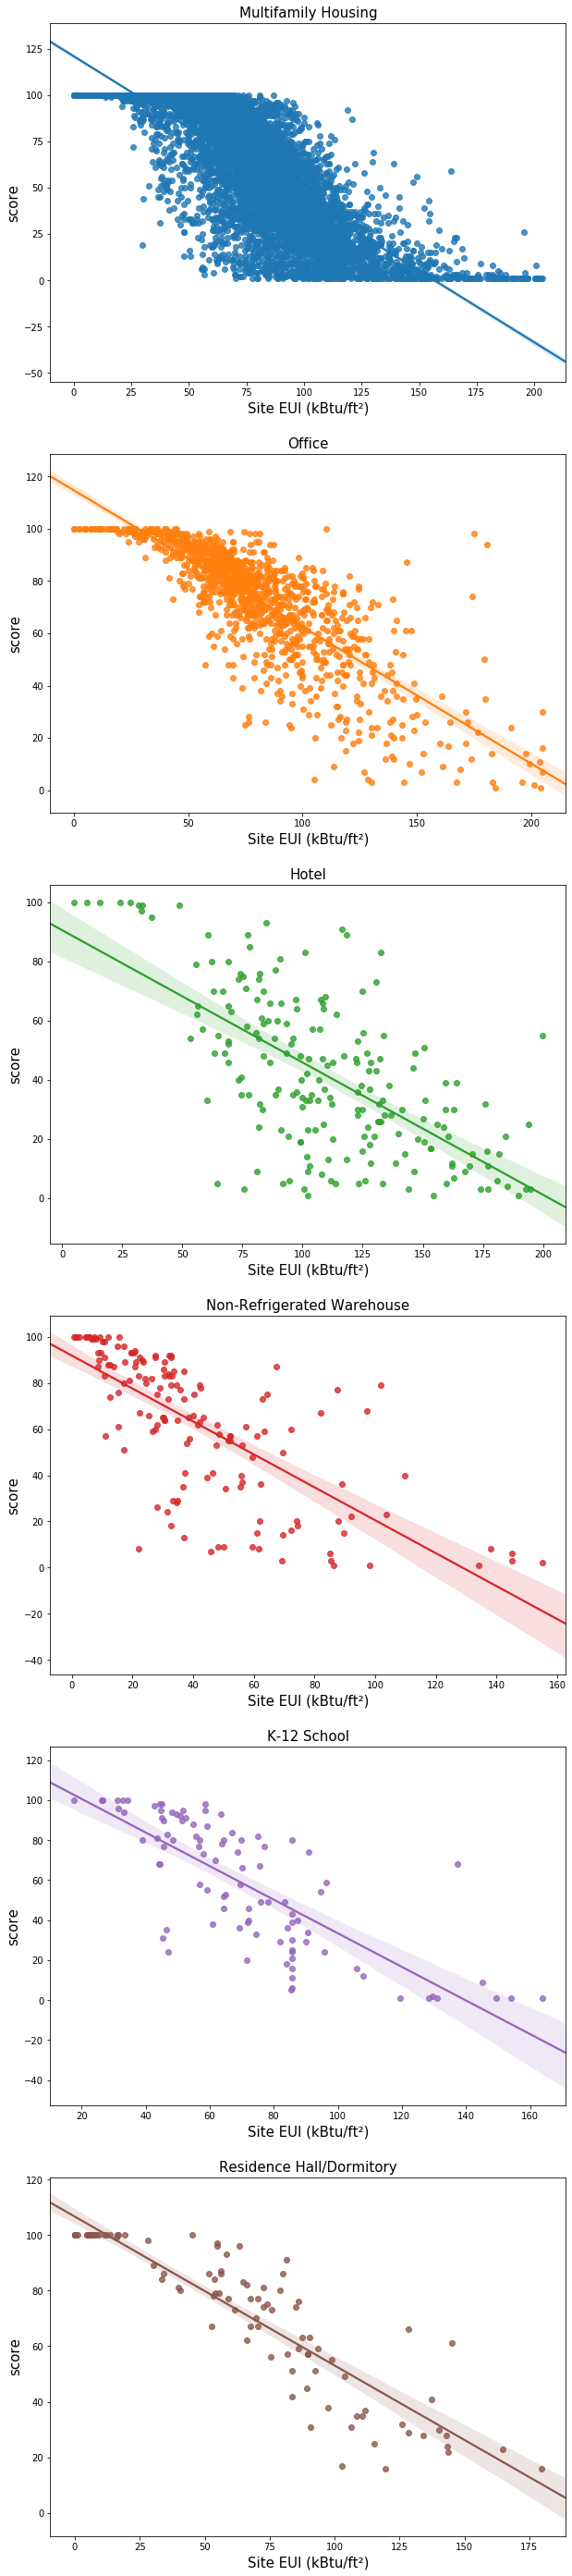

In [32]:
fig , ax = plt.subplots(6 , 1 , figsize = (10 , 50))

# 現在features並沒有'Largest Property Use Type'這個column
# 因為features只含有'Largest Property Use Type'做one hot encoding的數據
features['Largest Property Use Type'] = data.loc[data['score'].notnull()]['Largest Property Use Type']

# features['Largest Property Use Type']中超過100筆數據的types拿出來(都存在types)，看一下'score'隨'Site EUI (kBtu/ft²)'變化的趨勢
for i , type_ in enumerate(types):
    
    subset = features.loc[features['Largest Property Use Type'] == type_]

    sns.regplot(x = 'Site EUI (kBtu/ft²)' , y = 'score' ,  data = subset ,  x_jitter = 0.05 , ax = ax[i])
    ax[i].set_title(type_ , fontsize = 15)
    ax[i].set_xlabel('Site EUI (kBtu/ft²)' , fontsize = 15)
    ax[i].set_ylabel('score' , fontsize = 15)

非常明顯的負相關趨勢，像'Site EUI (kBtu/ft²)'這樣的特徵格外重要

### Pairs Plot
這個函數簡單實用！用`PairGrid` 還可以按需求去自己定義需要展示的部分

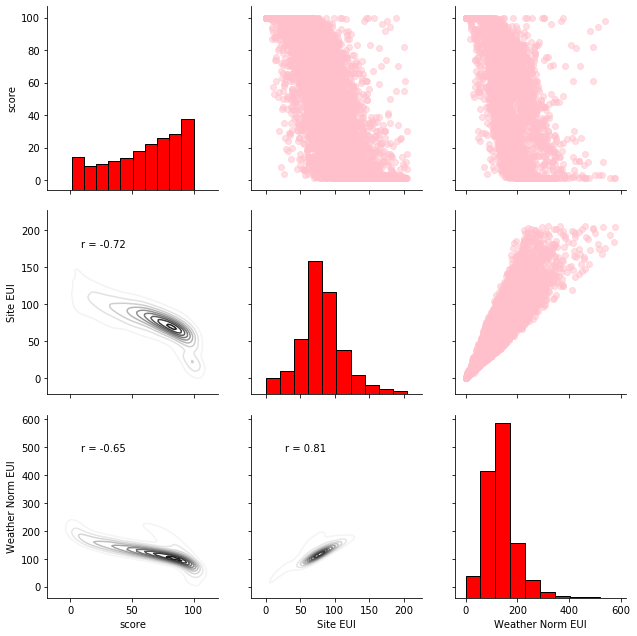

In [33]:
plot_data = features[['score' , 
                      'Site EUI (kBtu/ft²)' , 
                      'Weather Normalized Source EUI (kBtu/ft²)']]

# 將np.inf、-np.inf換成np.nan
plot_data = plot_data.replace([np.inf , -np.inf] , [np.nan , np.nan])

# 把名字縮短比較好塞進圖中
plot_data = plot_data.rename(columns = {'Site EUI (kBtu/ft²)': 'Site EUI' , 
                                        'Weather Normalized Source EUI (kBtu/ft²)': 'Weather Norm EUI'})

# Drop na values
plot_data = plot_data.dropna()

# Create the pairgrid object
grid = sns.PairGrid(data = plot_data , size = 3)

# Upper is a scatter plot
grid.map_upper(plt.scatter , color = 'pink' , alpha = 0.5)

# Diagonal is a histogram
grid.map_diag(plt.hist , color = 'red' , edgecolor = 'black')

# Function to calculate correlation coefficient between two columns
def corr_func(x , y , **kwargs):
    corr = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate('r = {:.2f}'.format(corr) ,
                xy = (0.2 , 0.8) ,
                xycoords = ax.transAxes ,
                size = 10)

# Bottom is correlation and density plot
grid.map_lower(corr_func)
grid.map_lower(sns.kdeplot , cmap = plt.cm.Greys)

### 特徵工程與特徵篩選
通過EDA已經對數據有了一定了解，比如我們發現建築物類型對得分的影響差別很大，接下來就是最重要的特徵工程環節

一般情況下我們分兩步走：特徵工程與特徵篩選：

- 特徵工程：<br>
  概括性來說就是盡可能的多在數據中提取特征，各種數值變換(比如平方，log)，特徵組合，分解等各種手段
  
  
- 特徵選擇：<br>
  就是找到最有價值的那些特徵作為我們模型的輸入，但是之前做了那麽多，可能有些是多餘的，有些還沒被發現，所以這倆階段都是一個反覆             在更新的過程。比如建模之後拿到了特征重要性，這就為特徵選擇做了參考，有些不重要的可以去掉，那些比較重要的，還可以再想辦法讓其             做更多變換和組合來促進我的模型。所以特徵工程並不是一次性就能解決的，需要通過各種結果來反覆斟酌

* 1.選擇數值特征和種類特征對他們進行log變換與One-hot encode
* 2.剔除掉共線特征，參考[multicollinearity](https://en.wikipedia.org/wiki/Multicollinearity)

In [34]:
# 挑出數值型數據
number_subset = data.select_dtypes('number')

# 對數值型數據做log1p變換
for col in number_subset.columns:
    # 不需要對'score'做變換
    if col != 'score':
        number_subset['log1p_' + col] = np.log1p(number_subset[col])

# 挑出類別型數據
object_subset = data[['Borough' , 'Largest Property Use Type']]

# 做one-hot encoding
object_subset = pd.get_dummies(object_subset)

features = pd.concat([number_subset , object_subset] , axis = 1)
features.shape

C:\Users\peng\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\peng\Anaconda3\lib\site-packages\pandas\core\series.py:856: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


(11319, 110)

### 剔除collinear特徵
挑出數據中`Site EUI` 和 `Weather Norm EUI`這兩個特徵來觀察，這兩個特徵描述的基本是同一件事

Text(0, 0.5, 'Weather Normalized Site EUI (kBtu/ft²)')

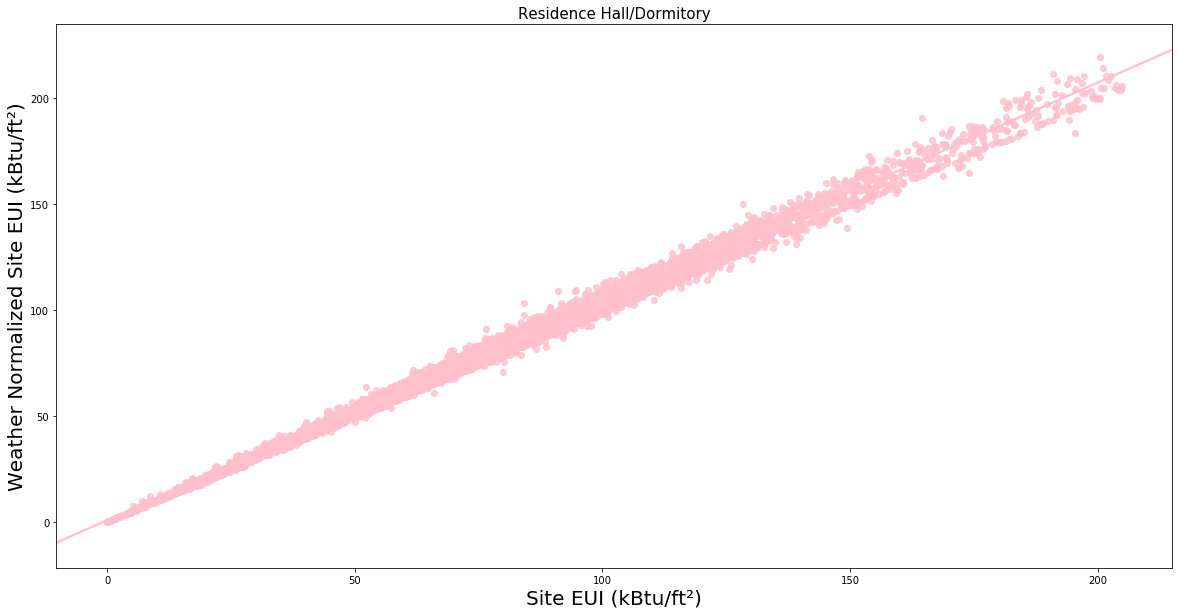

In [39]:
fig , ax = plt.subplots(1 , 1 , figsize = (20 , 10))
plot_data = features[['Weather Normalized Site EUI (kBtu/ft²)' , 'Site EUI (kBtu/ft²)']].dropna()

sns.regplot(x = 'Site EUI (kBtu/ft²)' , y = 'Weather Normalized Site EUI (kBtu/ft²)' , data = plot_data , x_jitter = 0.05 , color = 'pink' , ax = ax)
ax.set_title(type_ , fontsize = 15)
ax.set_xlabel('Site EUI (kBtu/ft²)' , fontsize = 20)
ax.set_ylabel('Weather Normalized Site EUI (kBtu/ft²)' , fontsize = 20)

若兩兩特徵為collinear，只要保留其中一個，能有效降低模型的複雜程度，防止overfitting

In [40]:
def remove_collinear_features(data , threshold):
    
    y = data['score'] # 將'score'先拿出來，不列入計算
    data = data.drop(columns = ['score'])
    
    corr_matrix = data.corr()
    feature_corr = pd.DataFrame(columns = [0 , 1 , 2])
    for i in range(0 , corr_matrix.shape[0]):
        for j in range(0 , i):
            if i != j:
                if abs(corr_matrix.iloc[i , j]) > threshold: # 將兩兩特徵相關係數大於threshold的特徵記錄起來
                    temp = [corr_matrix.index[i] , corr_matrix.columns[j] , corr_matrix.iloc[i , j]]
                    temp = pd.DataFrame(temp).T
                    feature_corr = pd.concat([feature_corr , temp] , axis = 0)
             
    drop = list(set(feature_corr[0]))
    data = data.drop(columns = drop)
    data['score'] = y
    
    feature_corr = feature_corr.sort_values(by = 2 , ascending = False)   
    
    return data , feature_corr
    
features , feature_corr = remove_collinear_features(features , 0.6)    

In [45]:
feature_corr.head(20)

,0,1,2
0,log1p_Latitude,Latitude,0.999999
0,Weather Normalized Site Electricity (kWh),Electricity Use - Grid Purchase (kBtu),0.999913
0,log1p_Year Built,Year Built,0.999866
0,Weather Normalized Site Natural Gas Use (therms),Natural Gas Use (kBtu),0.999404
0,log1p_Weather Normalized Site Electricity (kWh),log1p_Electricity Use - Grid Purchase (kBtu),0.999131
0,log1p_Source EUI (kBtu/ft²),log1p_Weather Normalized Source EUI (kBtu/ft²),0.998942
0,Source EUI (kBtu/ft²),Weather Normalized Source EUI (kBtu/ft²),0.998644
0,log1p_Weather Normalized Site EUI (kBtu/ft²),log1p_Site EUI (kBtu/ft²),0.998567
0,Weather Normalized Site EUI (kBtu/ft²),Site EUI (kBtu/ft²),0.996782
0,Property GFA - Self-Reported (ft²),Largest Property Use Type - Gross Floor Area (...,0.992954


In [47]:
features = features.dropna(axis = 1 , how = 'all')
features.shape

(11319, 65)

In [48]:
features.head()

,Order,Property Id,DOF Gross Floor Area,Year Built,Number of Buildings - Self-reported,Occupancy,Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Water Use (All Water Sources) (kgal),Latitude,Longitude,Community Board,Census Tract,log1p_Direct GHG Emissions (Metric Tons CO2e),log1p_Water Use (All Water Sources) (kgal),Borough_Staten Island,Largest Property Use Type_Adult Education,Largest Property Use Type_Automobile Dealership,Largest Property Use Type_Bank Branch,Largest Property Use Type_College/University,Largest Property Use Type_Convenience Store without Gas Station,Largest Property Use Type_Courthouse,Largest Property Use Type_Distribution Center,Largest Property Use Type_Enclosed Mall,Largest Property Use Type_Financial Office,Largest Property Use Type_Hospital (General Medical & Surgical),Largest Property Use Type_Hotel,Largest Property Use Type_K-12 School,Largest Property Use Type_Library,...,Largest Property Use Type_Museum,Largest Property Use Type_Non-Refrigerated Warehouse,Largest Property Use Type_Other,Largest Property Use Type_Other - Education,Largest Property Use Type_Other - Entertainment/Public Assembly,Largest Property Use Type_Other - Lodging/Residential,Largest Property Use Type_Other - Mall,Largest Property Use Type_Other - Public Services,Largest Property Use Type_Other - Recreation,Largest Property Use Type_Other - Services,Largest Property Use Type_Other - Specialty Hospital,Largest Property Use Type_Outpatient Rehabilitation/Physical Therapy,Largest Property Use Type_Parking,Largest Property Use Type_Performing Arts,Largest Property Use Type_Pre-school/Daycare,Largest Property Use Type_Refrigerated Warehouse,"Largest Property Use Type_Repair Services (Vehicle, Shoe, Locksmith, etc.)",Largest Property Use Type_Residence Hall/Dormitory,Largest Property Use Type_Residential Care Facility,Largest Property Use Type_Restaurant,Largest Property Use Type_Retail Store,Largest Property Use Type_Self-Storage Facility,Largest Property Use Type_Senior Care Community,Largest Property Use Type_Social/Meeting Hall,Largest Property Use Type_Strip Mall,Largest Property Use Type_Supermarket/Grocery Store,Largest Property Use Type_Urgent Care/Clinic/Other Outpatient,Largest Property Use Type_Wholesale Club/Supercenter,Largest Property Use Type_Worship Facility,score
12,15,2637863,NaN,1903,2,100,32.000000,7.5,0.0,22061.000000,NaN,NaN,NaN,NaN,5.022564,10.001612,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,93.0
17,20,2777309,NaN,1907,7,100,120.000000,8.7,0.9,NaN,NaN,NaN,NaN,NaN,7.968735,NaN,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN
18,21,2780056,NaN,1939,2,100,76.199997,3.5,0.0,5915.600098,NaN,NaN,NaN,NaN,7.330471,8.685517,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,72.0
19,22,4988574,179130.0,1939,1,100,75.699997,4.0,0.0,NaN,40.857943,-73.934962,12.0,281.0,6.843217,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,67.0
20,23,4988569,102150.0,1939,1,100,77.099998,2.6,0.0,NaN,40.858256,-73.934734,12.0,281.0,6.379444,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,80.0


### 數據集劃分



In [49]:
no_score = features[features['score'].isnull()] # 取出來當作測試集
score = features[features['score'].notnull()] # 取出來當作訓練集

print(no_score.shape)
print(score.shape)

(1858, 65)
(9461, 65)


In [50]:
features = score.drop(columns = 'score') 
targets = pd.DataFrame(score['score'])

# 將np.inf、-np.inf換成np.nan
features = features.replace([-np.inf , np.inf] ,  [np.nan , np.nan])

X , X_test , y , y_test = train_test_split(features , targets , test_size = 0.3 , random_state = 42)

print(X.shape)
print(X_test.shape)
print(y.shape)
print(y_test.shape)

(6622, 64)
(2839, 64)
(6622, 1)
(2839, 1)


### 衡量標準: Mean Absolute Error

以中位數當作預測的結果當作Baseline 

In [54]:
baseline_guess = np.median(y)
print('The baseline guess is a score of {:.2f}'.format(baseline_guess))
print('Baseline Performance on the test set : {:.2f}'.format(np.mean(abs(y_test - baseline_guess))[0]))

The baseline guess is a score of 66.00
Baseline Performance on the test set : 24.52


### 結果保存下來，建模再用

In [55]:
no_score.to_csv('data/no_score.csv' , index = False)
X.to_csv('data/training_features.csv' , index = False)
X_test.to_csv('data/testing_features.csv' , index = False)
y.to_csv('data/training_labels.csv' , index = False)
y_test.to_csv('data/testing_labels.csv' , index = False)